# Лабораторная работа №5

> Описание системы объяснения результатов вывода

* Научиться представлять атрибуты знаний;
* Разработать алгоритмы создания и редактирования компонентов баз знаний;
* Разрабатывать интерфейсы пользователей для редактора правил;
* Разработать форматы представления атрибутов и правил в информационных системах.

In [15]:
# Импорт необходимых библиотек
import numpy as np
import skfuzzy as fuzz
import yaml
import matplotlib.pyplot as plt

# Предел после которого считаем, что значение принадлежит множеству
fuzzy_limit = 0.25

# Анализируемые пользователи
users = [
    {'age': 20, 'income': 20000, 'credit_history': 0},
    {'age': 15, 'income': 25000, 'credit_history': 1},
    {'age': 35, 'income': 80000, 'credit_history': 1},
    {'age': 22, 'income': 30000, 'credit_history': 1},
    {'age': 80, 'income': 100000, 'credit_history': 1},
    {'age': 50, 'income': 80000, 'credit_history': 0},
    {'age': 30, 'income': 40000, 'credit_history': 1},
    {'age': 25, 'income': 60000, 'credit_history': 1},
    {'age': 45, 'income': 70000, 'credit_history': 0},
    {'age': 40, 'income': 55000, 'credit_history': 0.5},
    {'age': 22, 'income': 45000, 'credit_history': 0.5}
]

In [16]:
# Загрузка базы знаний из файла
with open('knowledge_base.yml', 'r') as file:
    knowledge_base = yaml.load(file, Loader=yaml.FullLoader)

In [17]:
# Функция подсчитывает степень принадлежности значения к каждому нечеткому множеству
def fuzzify(value, fuzzy_sets):
    memberships = {}
    for fuzzy_set_name, points in fuzzy_sets.items():
        x = np.linspace(0, max(points), 100)
        membership_function = fuzz.trapmf(x, points)
        memberships[fuzzy_set_name] = fuzz.interp_membership(x, membership_function, value)
    return memberships

In [18]:
# Функция оценивает условие для каждого подмножества антецедентов (предшествующих условий)
def eval_condition(attributes, condition, knowledge_base):
    output = []
    for sub_condition in condition:
        attr_name = sub_condition["attribute"]
        if attr_name in attributes:
            attr_value = attributes[attr_name]
            fuzzy_set = sub_condition.get("fuzzy_set")
            if fuzzy_set:
                output.append(
                    fuzzify(attr_value, knowledge_base["attributes"][attr_name]["fuzzy_sets"])[fuzzy_set] > fuzzy_limit)
            else:
                output.append(attr_value == sub_condition["value"])
        else:
            return False
    return all(output)

In [19]:
# Функция для визуализации
def visualize_fuzzy_sets(user, knowledge_base):
    fig, axs = plt.subplots(1, len(user), figsize=(15, 5))
    for idx, (attr_name, attr_value) in enumerate(user.items()):
        if attr_name in knowledge_base["attributes"]:
            attribute = knowledge_base["attributes"][attr_name]
            if "fuzzy_sets" in attribute:
                for fuzzy_set_name, points in attribute["fuzzy_sets"].items():
                    x = np.linspace(0, max(points), 100)
                    membership_function = fuzz.trapmf(x, points)
                    axs[idx].plot(x, membership_function, label=fuzzy_set_name)
                # Определение степени принадлежности
                memberships = fuzzify(user[attr_name], attribute["fuzzy_sets"])
                # Вычисление максимального уровня членства
                max_membership = max(memberships.values())
                for fuzzy_set_name, membership in memberships.items():
                    # Проверка, если степень принадлежности равна максимальной, то рисуем точку
                    if membership == max_membership:
                        axs[idx].scatter(user[attr_name], membership, color='yellow', s=100, label=f"user")

                axs[idx].set_title(attr_name)
                axs[idx].set_xlabel("Value")
                axs[idx].legend(loc="center right")
                axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

In [20]:
# Функция применяет правила из базы знаний к атрибутам пользователя
def apply_rules(attributes, rules, knowledge_base):
    for i, rule in enumerate(rules):
        if eval_condition(attributes, rule["antecedent"], knowledge_base):
            decision = rule["consequent"]["value"]
            print(f"Для пользователя с атрибутами {attributes}, решение: {decision}")
            print(f"Причина: было применено следующее правило из базы знаний:")
            print(f"Если:")
            for condition in rule["antecedent"]:
                print(f"  Атрибут '{condition['attribute']}' принадлежит к нечеткому множеству '{condition['fuzzy_set']}'")
            print(f"То:")
            print(f"  Атрибут '{rule['consequent']['attribute']}' принимает значение '{rule['consequent']['value']}'")
            return rule["consequent"]
    decision = "rejected"
    print(f"Для пользователя с атрибутами {attributes}, решение: {decision}")
    print(f"Причина: ни одно из правил из базы знаний не было применено.")
    return {"attribute": "credit", "value": decision}


Для пользователя с атрибутами {'age': 20, 'income': 20000, 'credit_history': 0}, решение: rejected
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'income' принадлежит к нечеткому множеству 'low'
То:
  Атрибут 'credit' принимает значение 'rejected'


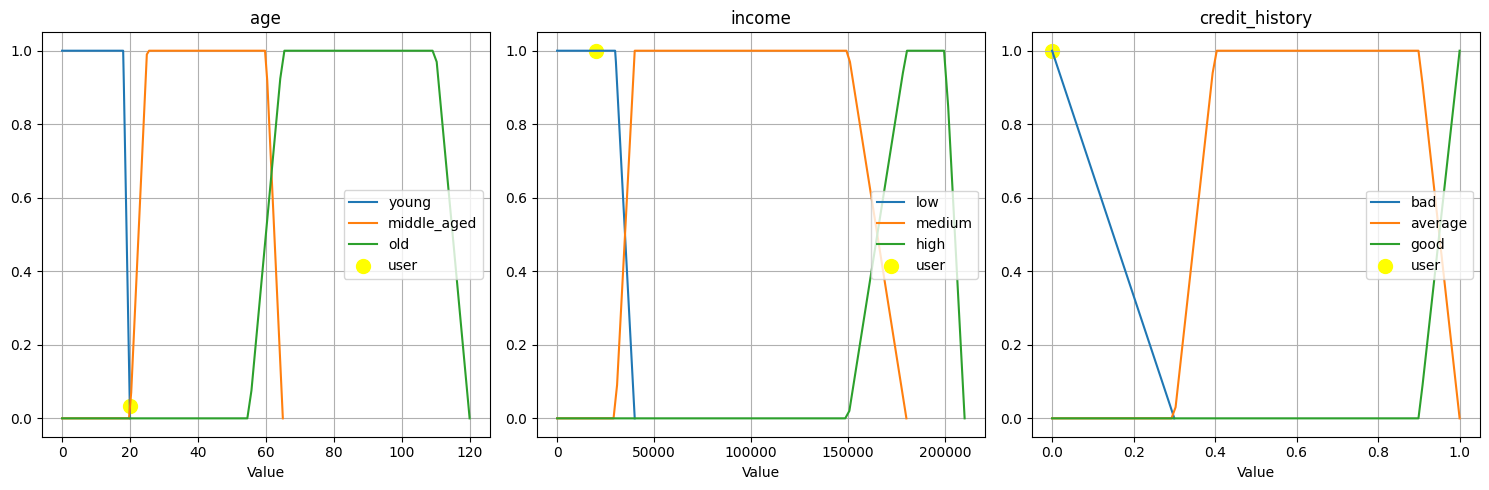

Для пользователя с атрибутами {'age': 15, 'income': 25000, 'credit_history': 1}, решение: rejected
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'young'
То:
  Атрибут 'credit' принимает значение 'rejected'


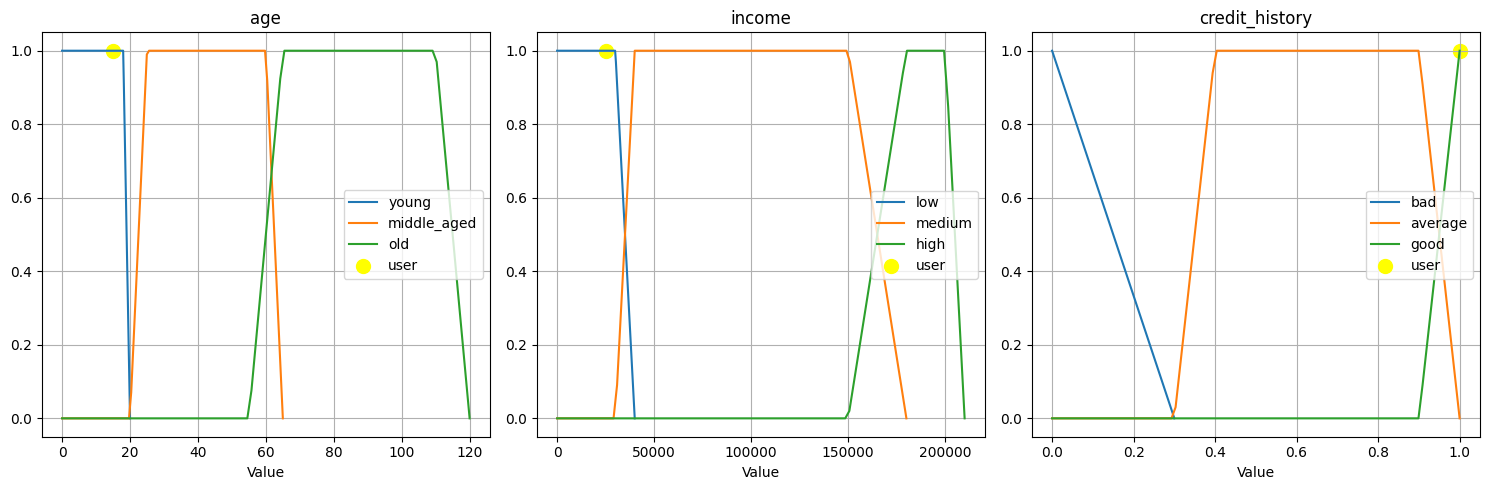

Для пользователя с атрибутами {'age': 35, 'income': 80000, 'credit_history': 1}, решение: approved
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'middle_aged'
  Атрибут 'income' принадлежит к нечеткому множеству 'medium'
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'good'
То:
  Атрибут 'credit' принимает значение 'approved'


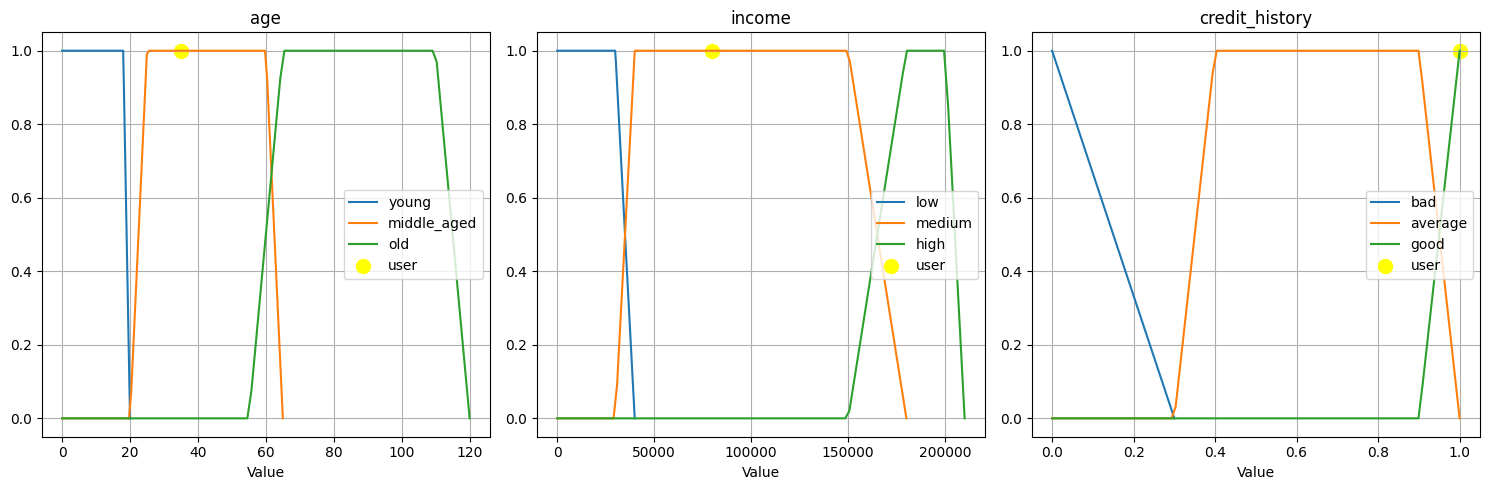

Для пользователя с атрибутами {'age': 22, 'income': 30000, 'credit_history': 1}, решение: rejected
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'income' принадлежит к нечеткому множеству 'low'
То:
  Атрибут 'credit' принимает значение 'rejected'


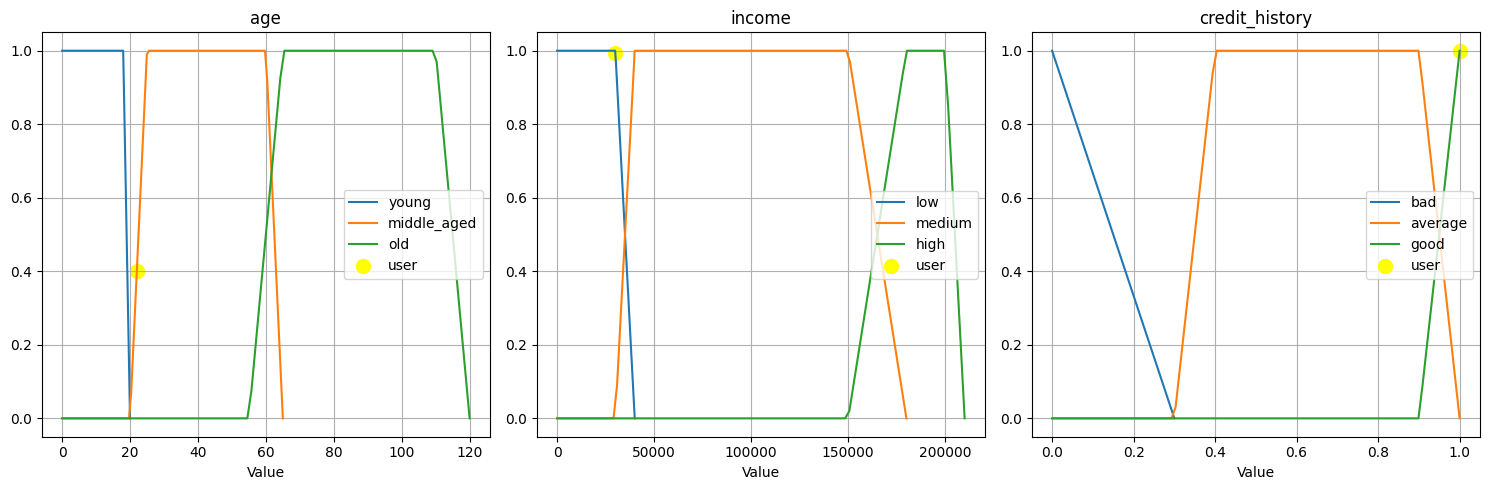

Для пользователя с атрибутами {'age': 80, 'income': 100000, 'credit_history': 1}, решение: rejected
Причина: ни одно из правил из базы знаний не было применено.


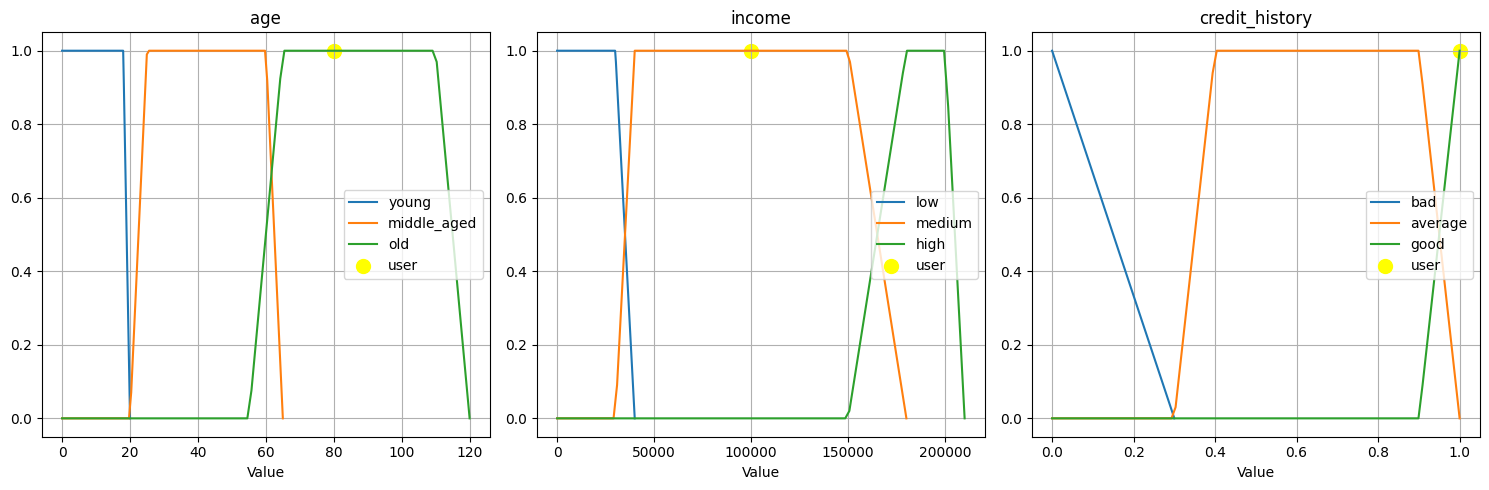

Для пользователя с атрибутами {'age': 50, 'income': 80000, 'credit_history': 0}, решение: rejected
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'bad'
То:
  Атрибут 'credit' принимает значение 'rejected'


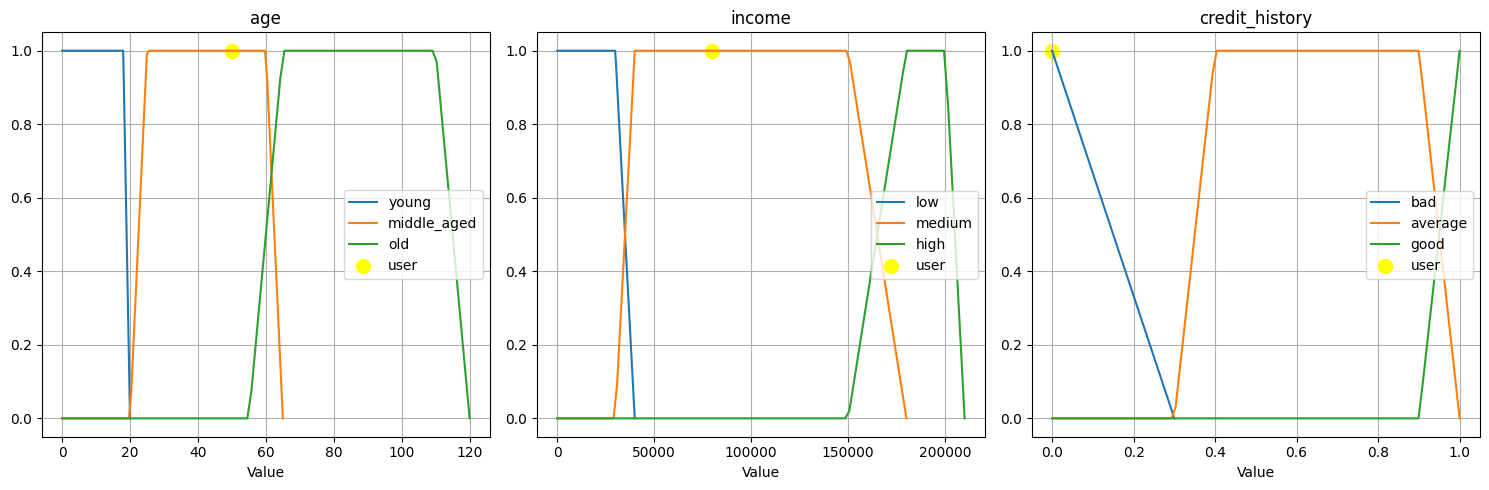

Для пользователя с атрибутами {'age': 30, 'income': 40000, 'credit_history': 1}, решение: approved
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'middle_aged'
  Атрибут 'income' принадлежит к нечеткому множеству 'medium'
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'good'
То:
  Атрибут 'credit' принимает значение 'approved'


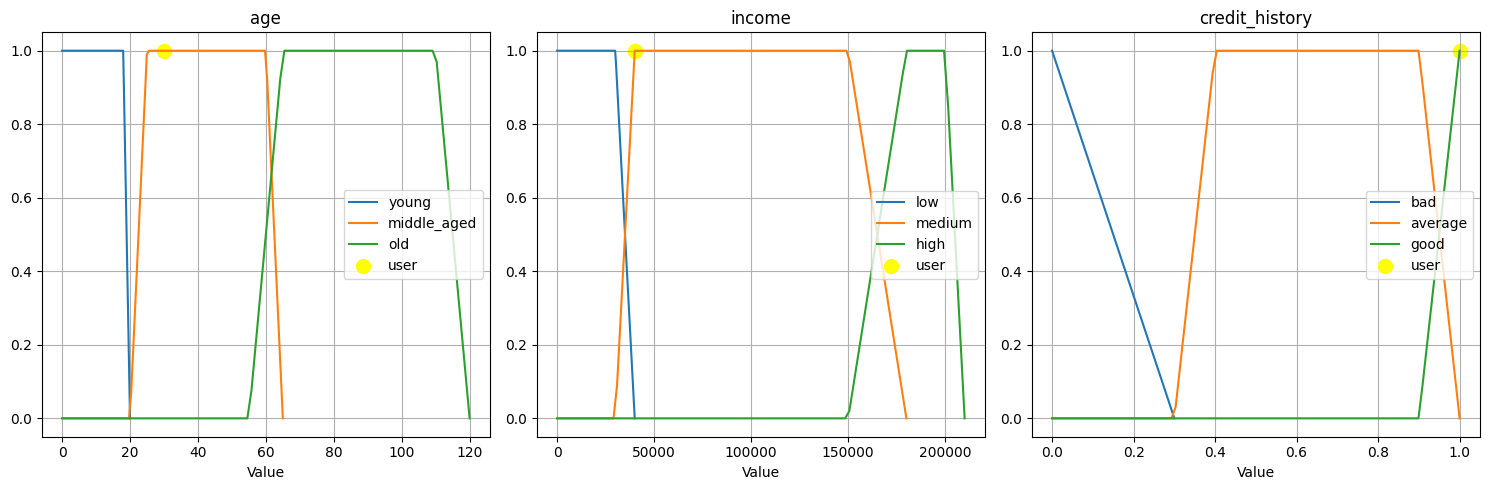

Для пользователя с атрибутами {'age': 25, 'income': 60000, 'credit_history': 1}, решение: approved
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'middle_aged'
  Атрибут 'income' принадлежит к нечеткому множеству 'medium'
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'good'
То:
  Атрибут 'credit' принимает значение 'approved'


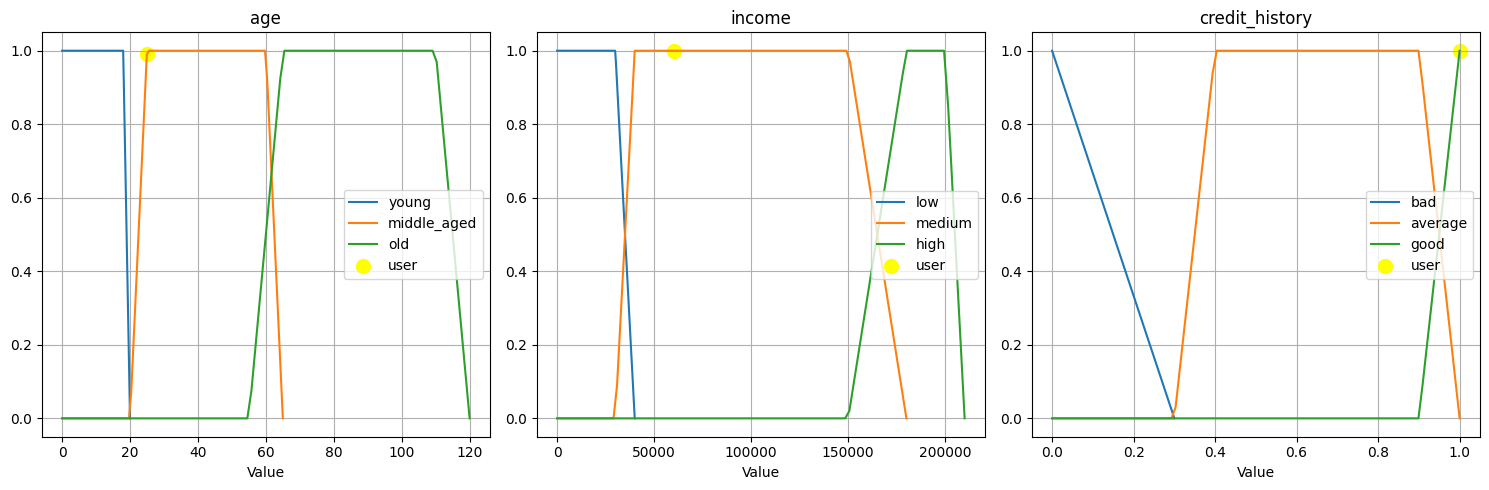

Для пользователя с атрибутами {'age': 45, 'income': 70000, 'credit_history': 0}, решение: rejected
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'bad'
То:
  Атрибут 'credit' принимает значение 'rejected'


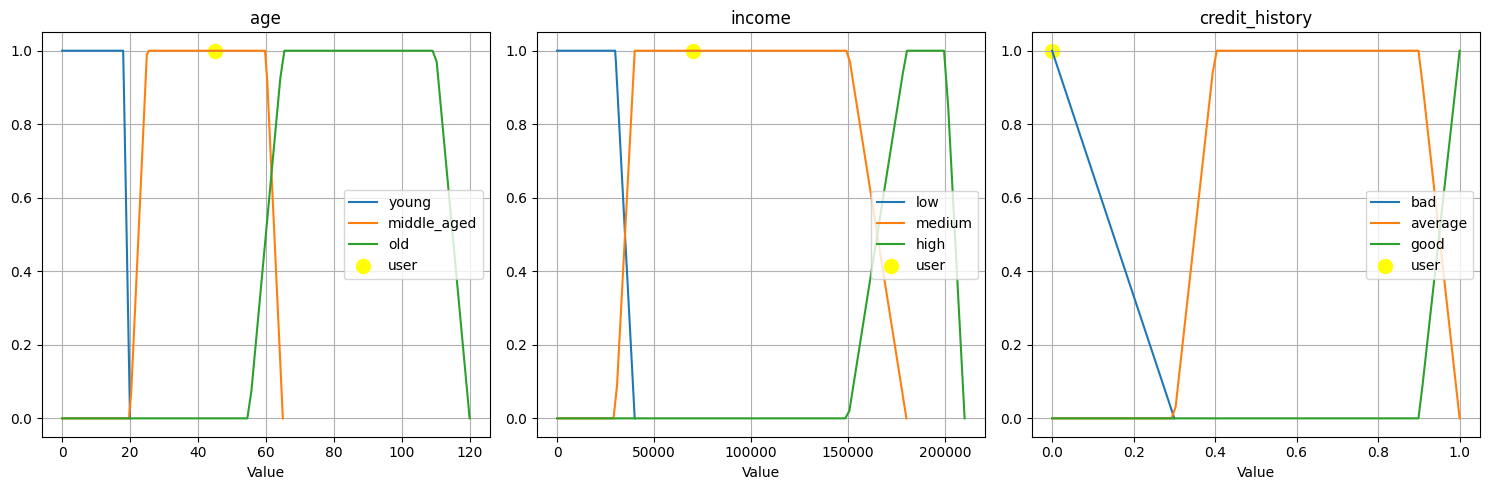

Для пользователя с атрибутами {'age': 40, 'income': 55000, 'credit_history': 0.5}, решение: approved
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'middle_aged'
  Атрибут 'income' принадлежит к нечеткому множеству 'medium'
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'average'
То:
  Атрибут 'credit' принимает значение 'approved'


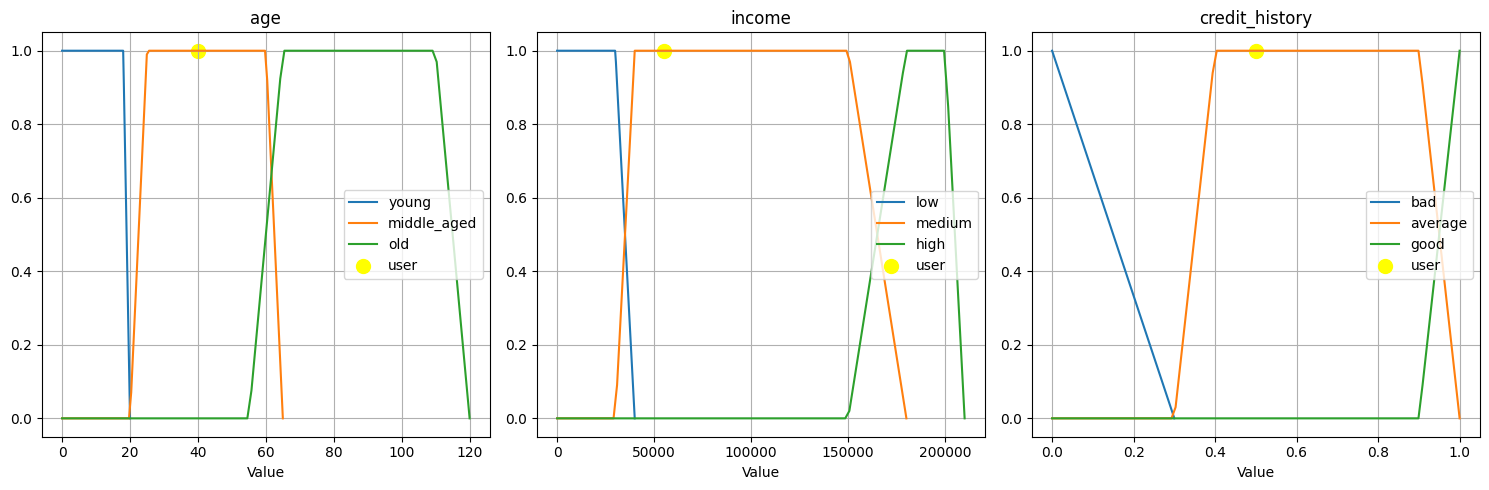

Для пользователя с атрибутами {'age': 22, 'income': 45000, 'credit_history': 0.5}, решение: approved
Причина: было применено следующее правило из базы знаний:
Если:
  Атрибут 'age' принадлежит к нечеткому множеству 'middle_aged'
  Атрибут 'income' принадлежит к нечеткому множеству 'medium'
  Атрибут 'credit_history' принадлежит к нечеткому множеству 'average'
То:
  Атрибут 'credit' принимает значение 'approved'


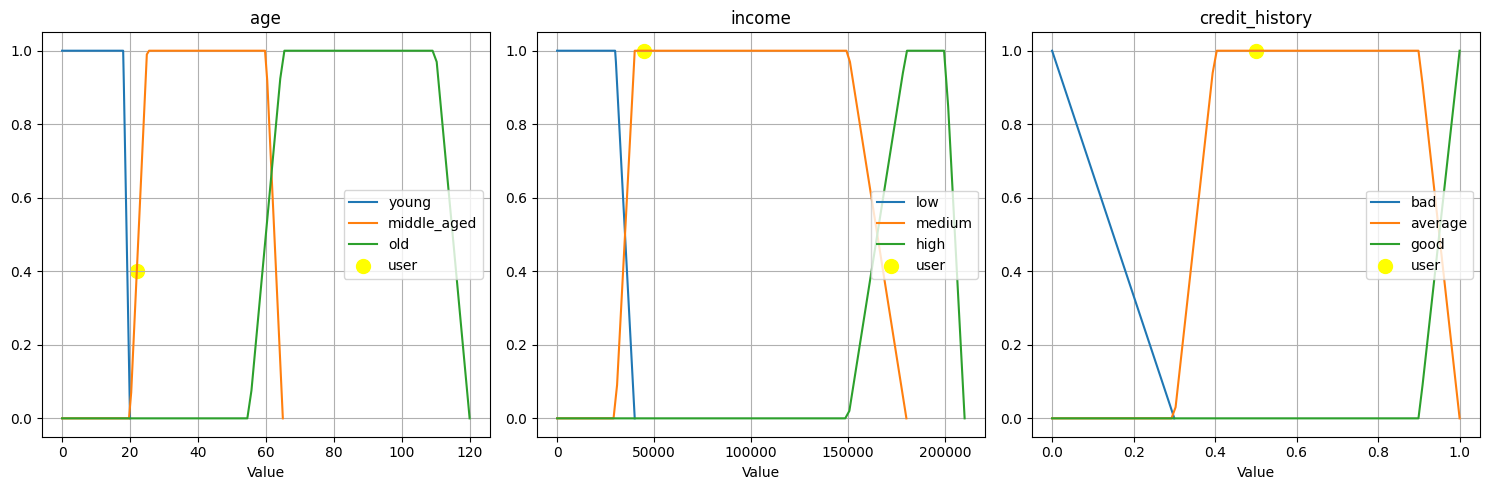

In [21]:
# Для каждого пользователя рисуем график
for user in users:
    apply_rules(user, knowledge_base['rules'], knowledge_base)
    visualize_fuzzy_sets(user, knowledge_base)